### Reator Químico com Duas Reações Competitivas

Um reator químico realiza duas reações paralelas e competitivas:

Reação principal: $A \rightarrow B$ (Produz o produto desejado).

Reação secundária: $A \rightarrow C$ (Produz um subproduto indesejado).

##### Objetivos:

Maximizar a produção de $B$: $f_1(x)$.

Minimizar a formação de $C$: $f_2(x)$.

##### Modelo Fenomenológico:

As taxas de reação dependem da concentração de reagentes e da temperatura ($T$), descritas pelas equações cinéticas:

$r_B=k_1e^{\frac{-E_1}{RT}}C_A$

$r_C=k_2e^{\frac{-E_2}{RT}}C_A$

onde:

$C_A$​ é a concentração do reagente $A$.

$T$ é a temperatura em Kelvin.

$k_1$​ e $k_2$​ são fatores pré-exponenciais das reações.

$E_1$​ e $E_2$​ são energias de ativação.

$R$ é a constante universal dos gases.

##### Variáveis de Controle:

$T \in [300,1000]$ (Temperatura do reator).

$C_A \in [0.1,2.0]$ (Concentração inicial do reagente).

##### Funções Objetivo:

$f_1(T,C_A)=−r_B(T,C_A)$ (maximizar $r_B$​, mas transformamos em minimização).

$f_2(T,CA)=r_C(T,C_A)$ (minimizar $r_C$).

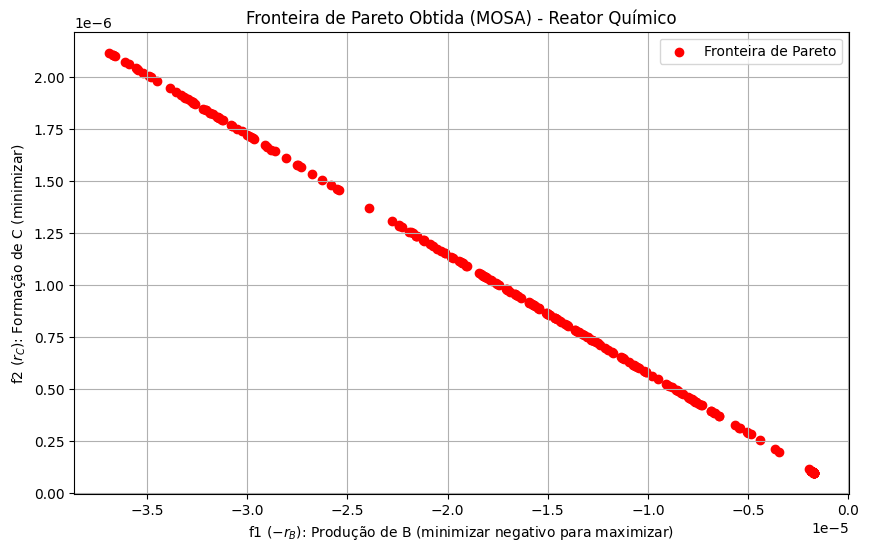

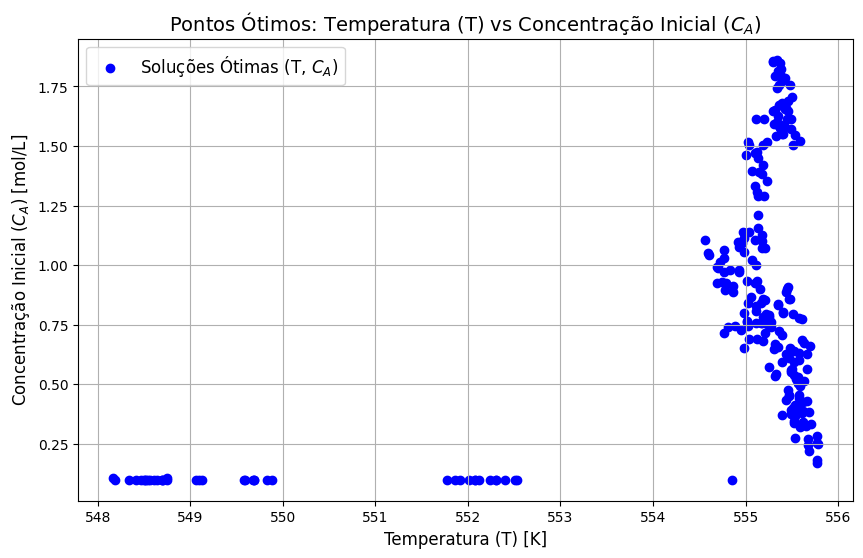

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros do modelo fenomenológico
R = 8.314  # Constante dos gases (J/mol*K)
k1, k2 = 1.0, 0.5  # Fatores pré-exponenciais (arbitrários para o exemplo)
E1, E2 = 50000, 60000  # Energias de ativação (J/mol)

# Funções cinéticas
def r_B(T, C_A):
    return k1 * np.exp(-E1 / (R * T)) * C_A

def r_C(T, C_A):
    return k2 * np.exp(-E2 / (R * T)) * C_A

# Funções objetivo
def f1(T, C_A):
    return -r_B(T, C_A)  # Maximizar produção de B (transformado em minimização)

def f2(T, C_A):
    return r_C(T, C_A)  # Minimizar formação de C

# Configurações do Simulated Annealing
np.random.seed(42)
T_initial = 1000   # Temperatura inicial (para o algoritmo MOSA)
T_min = 1e-3       # Temperatura mínima
alpha = 0.9        # Taxa de resfriamento
max_iter = 500     # Iterações por temperatura

# Limites do espaço de busca
bounds = [(300, 1000), (0.1, 2.0)]  # [T_min, T_max], [C_A_min, C_A_max]

# Inicialização
current_solution = np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds])
best_solutions = []  # Para armazenar as soluções não-dominadas
T = T_initial

# Função de aceitação (Probabilidade de aceitar piores soluções)
def acceptance_probability(delta, temperature):
    return np.exp(-delta / temperature)

# Função de avaliação (agregação ponderada para escolha probabilística)
def aggregate_objective(f1_val, f2_val, weights):
    return weights[0] * f1_val + weights[1] * f2_val

# Simulated Annealing principal
while T > T_min:
    for _ in range(max_iter):
        # Gerar nova solução no espaço de busca
        new_solution = current_solution + np.random.uniform(-0.1, 0.1, size=2)
        new_solution = np.clip(new_solution, [b[0] for b in bounds], [b[1] for b in bounds])

        # Avaliar os objetivos
        current_f1, current_f2 = f1(*current_solution), f2(*current_solution)
        new_f1, new_f2 = f1(*new_solution), f2(*new_solution)

        # Determinar se aceita a nova solução
        weights = np.random.dirichlet(np.ones(2))  # Pesos aleatórios
        current_agg = aggregate_objective(current_f1, current_f2, weights)
        new_agg = aggregate_objective(new_f1, new_f2, weights)

        if new_agg < current_agg or np.random.rand() < acceptance_probability(new_agg - current_agg, T):
            current_solution = new_solution

        # Adicionar a solução ao conjunto de soluções não-dominadas, se aplicável
        dominated = False
        non_dominated = []
        for sol in best_solutions:
            if (new_f1 <= sol[0] and new_f2 <= sol[1]) and (new_f1 < sol[0] or new_f2 < sol[1]):
                dominated = True
                break
            elif not ((sol[0] <= new_f1 and sol[1] <= new_f2) and (sol[0] < new_f1 or sol[1] < new_f2)):
                non_dominated.append(sol)
        if not dominated:
            non_dominated.append((new_f1, new_f2, new_solution))
        best_solutions = non_dominated

    # Resfriar o sistema
    T *= alpha

# Extração dos resultados
pareto_front = np.array([[sol[0], sol[1]] for sol in best_solutions])
solutions = np.array([sol[2] for sol in best_solutions])

# Visualizar o resultado
plt.figure(figsize=(10, 6))
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c='red', label='Fronteira de Pareto')
plt.title('Fronteira de Pareto Obtida (MOSA) - Reator Químico')
plt.xlabel('f1 ($-r_B$): Produção de B (minimizar negativo para maximizar)')
plt.ylabel('f2 ($r_C$): Formação de C (minimizar)')
plt.legend()
plt.grid()
plt.show()

pareto_front, solutions

import matplotlib.pyplot as plt

# Plot dos pontos ótimos de T e C_A
plt.figure(figsize=(10, 6))
plt.scatter(solutions[:, 0], solutions[:, 1], color='blue', label="Soluções Ótimas (T, $C_A$)")
plt.title("Pontos Ótimos: Temperatura (T) vs Concentração Inicial ($C_A$)", fontsize=14)
plt.xlabel("Temperatura (T) [K]", fontsize=12)
plt.ylabel("Concentração Inicial ($C_A$) [mol/L]", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()
